In [15]:
#     API Alpaca
#     Data cleanup
#     Consumer Discretionary Monte Carlo = XLY
#     Consumer Staples Monte Carlo = XLP
#     SP500 GROWTH Monte Carlo = SGX


In [16]:
#Import libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
import requests
import os 


%matplotlib inline


In [17]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
APCA_API_KEY_ID = os.getenv("APCA_API_KEY")
APCA_SECRET_KEY = os.getenv("APCA_SECRET_KEY")

api = tradeapi.REST(APCA_API_KEY_ID, APCA_SECRET_KEY, api_version='v2')
type(APCA_API_KEY_ID)


str

In [18]:
#Use alpha vantage to get historic quotes for XLY,XLP,SGX. This goes back 20 years.

xly_df = api.alpha_vantage.historic_quotes('XLY', adjusted=True, output_format='pandas')
xly_df.head()

xlp_df = api.alpha_vantage.historic_quotes('XLP', adjusted=True, output_format='pandas')
#xlp_df.tail()

sgx_df = api.alpha_vantage.historic_quotes('SGX', adjusted=True, output_format='pandas')
#sgx_df.head()


In [19]:
xly_df.head()


,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-04-29,117.03,118.21,116.380,117.33,117.33,4998795.0,0.0,1.0
2020-04-28,116.49,116.90,114.220,114.80,114.80,4729438.0,0.0,1.0
2020-04-27,113.40,115.09,113.290,114.35,114.35,4118447.0,0.0,1.0
2020-04-24,111.52,112.75,110.495,112.25,112.25,2914498.0,0.0,1.0
2020-04-23,110.96,112.02,109.980,110.38,110.38,4129555.0,0.0,1.0


In [20]:
#DATA CLEANUP

#Select the one column we need,  "adjusted close", and drop the others

xly_df = xly_df['5. adjusted close']
xly_df.head()

xlp_df = xlp_df['5. adjusted close']
xlp_df.head()

sgx_df = sgx_df['5. adjusted close']
sgx_df.head()

#Use concat to put the data in one dataframe
concat_df = pd.concat([xly_df, xlp_df, sgx_df], axis = "columns", join = "inner")
concat_df.head()
    

,5. adjusted close,5. adjusted close,5. adjusted close
date,,,
2020-04-28,114.80,59.21,1846.23
2020-04-27,114.35,58.88,1868.83
2020-04-24,112.25,58.71,1850.60
2020-04-23,110.38,58.09,1823.75
2020-04-22,110.41,58.61,1826.15


In [21]:
#print column names
print(concat_df.columns)


Index(['5. adjusted close', '5. adjusted close', '5. adjusted close'], dtype='object')


In [22]:
#Change column names to avoid confusion
columns = ['XLY close', 'XLP close', 'SGX close']
concat_df.columns = columns
concat_df.head()


,XLY close,XLP close,SGX close
date,,,
2020-04-28,114.80,59.21,1846.23
2020-04-27,114.35,58.88,1868.83
2020-04-24,112.25,58.71,1850.60
2020-04-23,110.38,58.09,1823.75
2020-04-22,110.41,58.61,1826.15


In [23]:
#add another column to get daily returns of XLY
daily_returns_xly = xly_df.pct_change()
concat_df['XLY_return']= daily_returns_xly 

#add another column to get daily returns of XLP
daily_returns_xlp = xlp_df.pct_change()
concat_df['XLP_return']= daily_returns_xlp 

#add another column to get daily returns of SGX
daily_returns_sgx = sgx_df.pct_change()
concat_df['SGX_return']= daily_returns_sgx 

concat_df.head()

,XLY close,XLP close,SGX close,XLY_return,XLP_return,SGX_return
date,,,,,,
2020-04-28,114.80,59.21,1846.23,-0.021563,0.004240,NaN
2020-04-27,114.35,58.88,1868.83,-0.003920,-0.005573,0.012241
2020-04-24,112.25,58.71,1850.60,-0.018365,-0.002887,-0.009755
2020-04-23,110.38,58.09,1823.75,-0.016659,-0.010560,-0.014509
2020-04-22,110.41,58.61,1826.15,0.000272,0.008952,0.001316


In [24]:
#check for nulls

concat_df.isnull().sum()

XLY close     0
XLP close     0
SGX close     0
XLY_return    0
XLP_return    0
SGX_return    1
dtype: int64

In [25]:
# Drop nulls
concat_df.dropna(inplace=True)

#count nulls again
concat_df.isnull().sum()

XLY close     0
XLP close     0
SGX close     0
XLY_return    0
XLP_return    0
SGX_return    0
dtype: int64

In [26]:
# Checking for duplicate rows
concat_df.duplicated()

date
2020-04-27    False
2020-04-24    False
2020-04-23    False
2020-04-22    False
2020-04-21    False
              ...  
2000-05-05    False
2000-05-04    False
2000-05-03    False
2000-05-02    False
2000-05-01    False
Length: 5029, dtype: bool

In [27]:
# drop duplicates
concat_df.drop_duplicates(inplace=True)

In [28]:
concat_df.sort_index(inplace=True, ascending=True)

In [29]:
concat_df.head()

,XLY close,XLP close,SGX close,XLY_return,XLP_return,SGX_return
date,,,,,,
2000-05-01,22.9368,14.2400,885.57,0.006817,-0.002647,0.018564
2000-05-02,22.7815,14.2778,869.43,0.049752,0.000000,0.021129
2000-05-03,21.7018,14.2778,851.44,0.016740,0.000000,0.006073
2000-05-04,21.3445,14.2778,846.30,-0.012578,-0.022825,-0.022884
2000-05-05,21.6164,14.6113,866.12,0.002886,-0.020250,0.016967


In [40]:
#calculate value of standard deviation of daily returns
#use the std function to calculate the standard deviation of daily returns for XLY, XLP, & SGX

std_xly_daily_returns = concat_df.std()['XLY_return']
std_xly_daily_returns

std_xlp_daily_returns = concat_df.std()['XLP_return']
std_xlp_daily_returns

std_sgx_daily_returns = concat_df.std()['SGX_return']
std_sgx_daily_returns

0.012617444243397937

In [ ]:
#calculate average of daily returns
std_xly_daily_returns = concat_df.mean()['XLY_return']
std_xly_daily_returns

std_xlp_daily_returns = concat_df.mean()['XLP_return']
std_xlp_daily_returns

std_sgx_daily_returns = concat_df.mean()['SGX_return']
std_sgx_daily_returns

In [30]:
#Check datatypes

concat_df.dtypes

XLY close     float64
XLP close     float64
SGX close     float64
XLY_return    float64
XLP_return    float64
SGX_return    float64
dtype: object

In [31]:
#check counts
concat_df.count()

XLY close     5029
XLP close     5029
SGX close     5029
XLY_return    5029
XLP_return    5029
SGX_return    5029
dtype: int64

In [32]:
#use describe to explore data
concat_df.describe()

,XLY close,XLP close,SGX close,XLY_return,XLP_return,SGX_return
count,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000
mean,46.860639,28.637602,867.367193,-0.000221,-0.000238,-0.000067
std,30.557874,14.745611,403.188571,0.014147,0.009538,0.012617
min,13.621800,11.666100,363.990000,-0.104402,-0.083707,-0.113694
25%,24.377900,16.229300,575.750000,-0.007072,-0.005115,-0.005796
50%,31.289600,20.780600,684.000000,-0.000800,-0.000444,-0.000615
75%,69.780000,42.664600,1126.220000,0.005794,0.004199,0.004855
max,131.682600,64.409400,2120.379900,0.145063,0.103699,0.139774


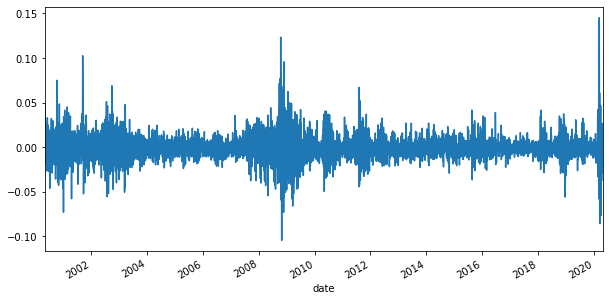

In [33]:
#plot daily returns of XLY

concat_df['XLY_return'].plot(figsize=(10,5))

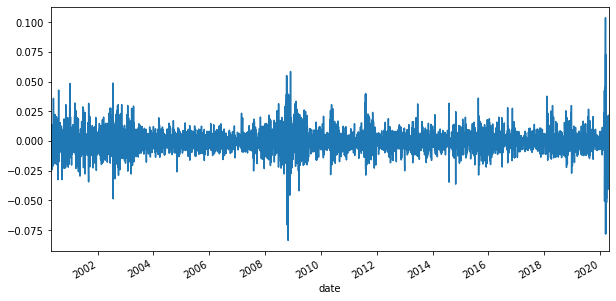

In [34]:
#plot daily returns of XLP

concat_df['XLP_return'].plot(figsize=(10,5))

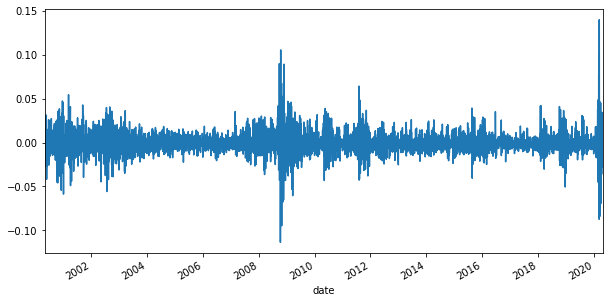

In [35]:
#plot daily returns of SGX

concat_df['SGX_return'].plot(figsize=(10,5))

In [36]:
# Calculate the cumulative returns using the 'cumprod()' function
cumulative_returns_xly = (1 + concat_df['XLP_return']).cumprod()
cumulative_returns_xlp = (1 + concat_df['XLY_return']).cumprod()
cumulative_returns_sgx = (1 + concat_df['SGX_return']).cumprod()

cumulative_returns_xly.head()

date
2000-05-01    0.997353
2000-05-02    0.997353
2000-05-03    0.997353
2000-05-04    0.974588
2000-05-05    0.954852
Name: XLP_return, dtype: float64

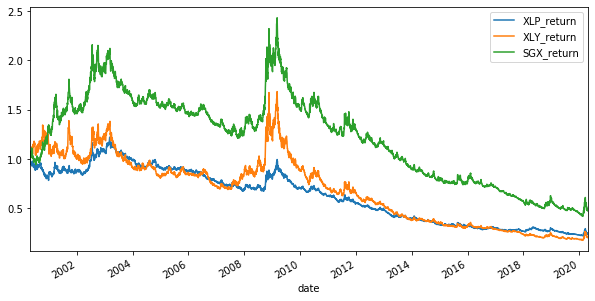

In [37]:
#plot cumulative returns

cumulative_returns_xly.plot(figsize=(10,5), legend=True)
cumulative_returns_xlp.plot(figsize=(10,5), legend=True)
cumulative_returns_sgx.plot(figsize=(10,5), legend=True)

In [88]:
#need to check on dividend

In [44]:
#run the monte carlo simulation and save results to DataFrame
#Set the number of trading days and get last closing price of xly, xlp, and sgx from DataFrame

num_trading_days = 252 * 3
xly_last_price = concat_df['XLY close'][-1]

xlp_last_price = concat_df['XLP close'][-1]

sgx_last_price = concat_df['SGX close'][-1]

In [45]:
print(xly_last_price)

114.35


In [46]:
#initialize the simulated prices list with the last closing prices

simulated_xly_prices = [xly_last_price]

simulated_xlp_prices = [xlp_last_price]

simulated_sgx_prices = [sgx_last_price]

In [ ]:
#simulate the returns for 252 * 3 trading days

for i in range(num_trading_days):
    #calculate the simulated price using the last price within the list
    latest_simulated_xly_price = simulated_xly_prices[-1] * (1 + np. random.normal(avg_daily_return, std_xly_daily_returns))
    